# 使用自定义m_axi 数据stream化模块对，实现内存数据流化和流化数据的收集存储
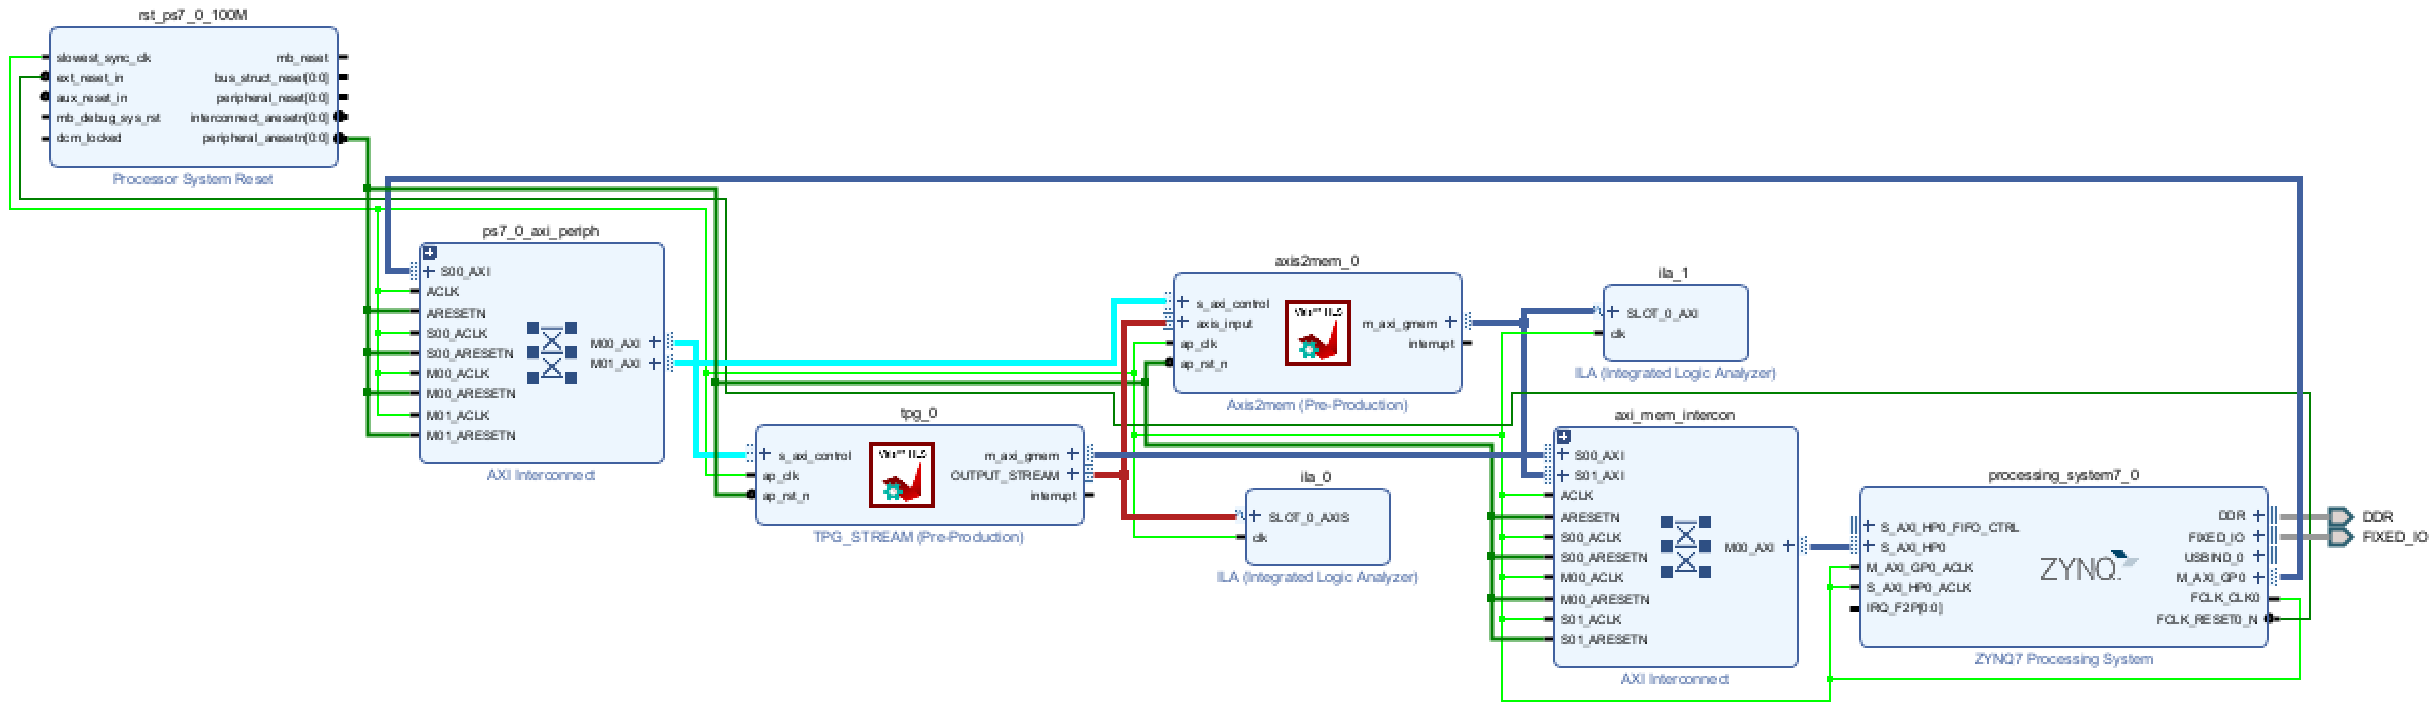  
tpg (TEST PATTERN GENERATOR) 寄存器地址   
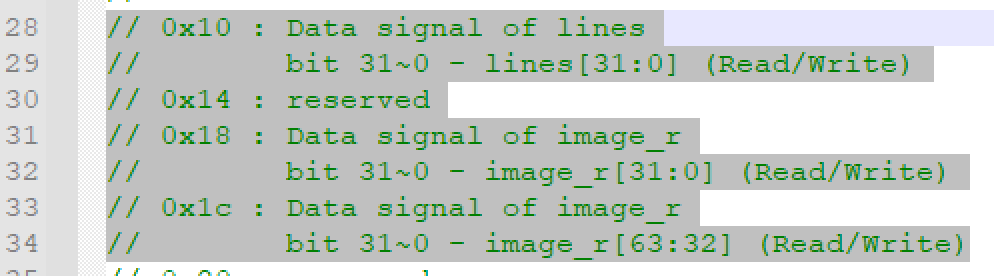   
axis2mem 寄存器地址   
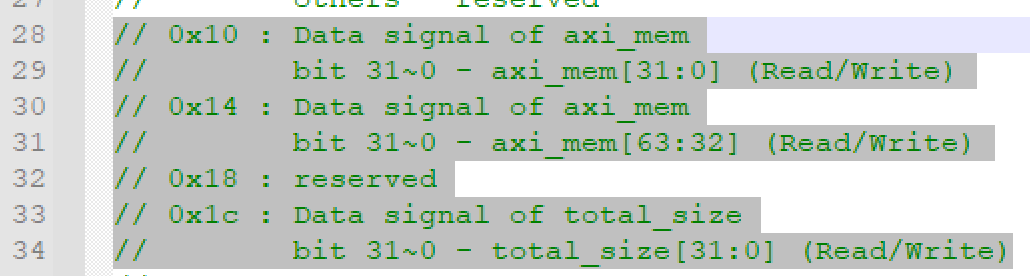

## 硬件设计应通过standalone程序联合vivado ila调试正确后，使用pynq 驱动

In [1]:
import numpy as np
from pynq import allocate, Overlay

## 准备硬件，本测试只针对图像处理数据，如需要HDMI out,增加相应硬件设计即可

In [2]:
hw_design = Overlay('./overlay/axi2stream.bit')

In [3]:
tpg = hw_design.tpg_0
axis2mem = hw_design.axis2mem_0

## 准备输入数据

In [4]:
in_buffer = allocate(shape=640, dtype=np.uint32)    # 所有的行数据相同于第一行，即仅需要一行数据
in_buffer[:] = range(640,0,-1)
in_buffer.flush()

## tpg 参数输入

In [5]:
tpg.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  lines = Register(lines=write-only),
  image_r_1 = Register(image_r=write-only),
  image_r_2 = Register(image_r=write-only)
}

In [6]:
tpg.register_map.image_r_1 = in_buffer.physical_address
tpg.register_map.image_r_2 = 0

In [7]:
tpg.register_map.lines = 480

## axis2mem 参数输入

In [8]:
out_buffer = allocate(shape=640*480, dtype=np.uint32)    # 接收按单一行形式

In [9]:
axis2mem.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  axi_mem_1 = Register(axi_mem=write-only),
  axi_mem_2 = Register(axi_mem=write-only),
  total_size = Register(total_size=write-only)
}

In [10]:
axis2mem.register_map.axi_mem_1 = out_buffer.physical_address
axis2mem.register_map.axi_mem_2 =0

In [11]:
axis2mem.register_map.total_size = 640*480

## 启动2个IPs,按反序先后

In [12]:
axis2mem.register_map.CTRL.AP_START = 1
tpg.register_map.CTRL.AP_START = 1

In [13]:
tpg.register_map.CTRL.AP_DONE

1

In [14]:
axis2mem.register_map.CTRL.AP_DONE

1

In [15]:
## 更新DCache给out_buffer

In [16]:
out_buffer.invalidate()

In [17]:
out_buffer

PynqBuffer([640, 639, 638, ...,   3,   2,   1], dtype=uint32)